# Multiple Linear Regression

Multiple linear regression helps us to estimate the linear relationship between one continuous **dependent variable** and two or more **independent variables**. For data science professionals, this is a useful skill because it allows you to compare more than one variable to the variable you're measuring against. This provides the opportunity for much more thorough and flexible analysis.

## Project Scenerio

For this project, we will be analyzing a small business' historical marketing promotion data. Each row corresponds to an independent marketing promotion where their business uses TV, social media, radio, and influencer promotions to increase sales. 

They have previously worked to find a single variable that predicts sales, and now they hope to expand this analysis to include other variables that can help them target their marketing efforts.


## Our Task

To address the business request, we will conduct a multiple linear regression analysis to estimate sales from a combination of independent variables. This will include:

* **Exploring and cleaning data**
* **Using plots and descriptive statistics to select the independent variables**
* **Creating a fitting multiple linear regression model**
* **Checking model assumptions**
* **Interpreting model outputs and communicating the results to non-technical stakeholders**

## Imports

In [3]:
# 📦 Data Handling
import pandas as pd
import numpy as np

# 📊 Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 📈 Statistical Modeling
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 📐 Statistical Tests
from scipy import stats
from scipy.stats import f


In [4]:
data = pd.read_csv('marketing_sales_data.csv')  # Load the dataset from a CSV file into a pandas DataFrame.
data.head()  # Display the first five rows of the DataFrame to get a quick overview of the data.


,TV,Radio,Social Media,Influencer,Sales
0,Low,3.518070,2.293790,Micro,55.261284
1,Low,7.756876,2.572287,Mega,67.574904
2,High,20.348988,1.227180,Micro,272.250108
3,Medium,20.108487,2.728374,Mega,195.102176
4,High,31.653200,7.776978,Nano,273.960377


---

## Data exploration

#### Familiarizing the data's features

Let's start with an exploratory data analysis to familiarize with the data and prepare it for modeling.

The features in the data are:

* TV promotional budget (in "Low," "Medium," and "High" categories)
* Social media promotional budget (in millions of dollars)
* Radio promotional budget (in millions of dollars)
* Sales (in millions of dollars)
* Influencer size (in "Mega," "Macro," "Micro," and "Nano" categories)

We make EDA before constructing a multiple linear regression model for: 
* Understanding which variables are present in the data
* Reviewing the distribution of features, such as minimum, mean, and maximum values
* Plotting the relationship between the independent and dependent variables to visualize which features have a linear relationship
* Identifying issues with the data, such as incorrect values (e.g., typos) or missing values

<Axes: xlabel='TV', ylabel='Sales'>

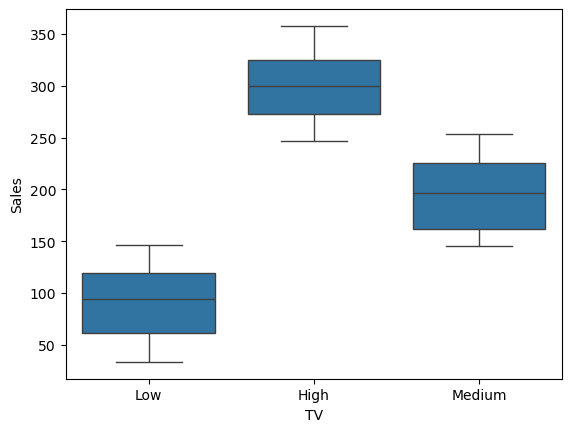

In [5]:
sns.boxplot(x = "TV", y = "Sales", data = data) # Create a boxplot with TV and Sales.

<Axes: xlabel='Influencer', ylabel='Sales'>

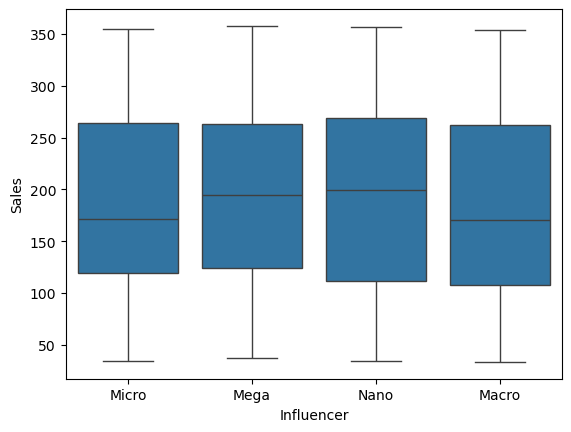

In [6]:
sns.boxplot(x = "Influencer", y = "Sales", data = data) # Create a boxplot with Influencer and Sales.

### Create a pairplot of the data

We create a pairplot to visualize the relationship between the continous variables in `data`.

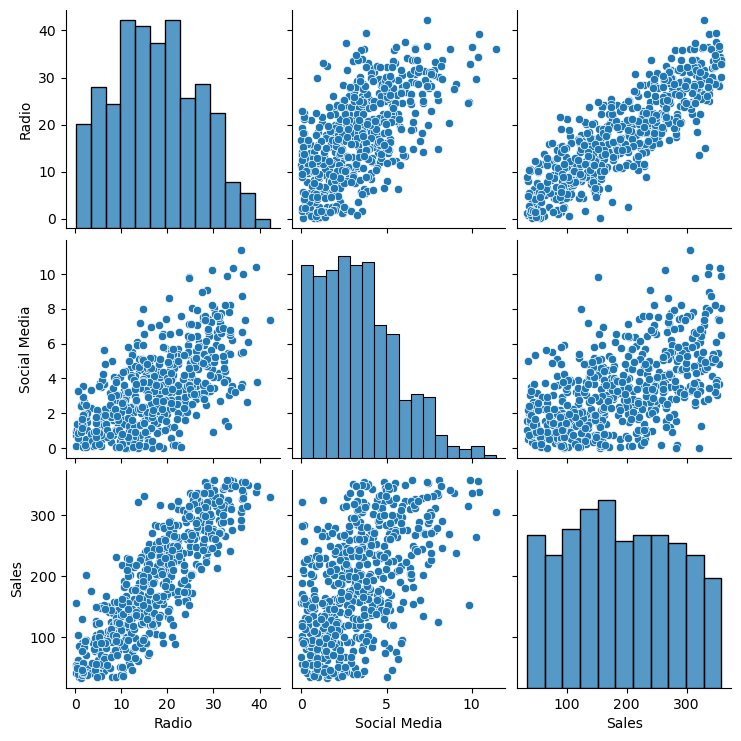

In [7]:
sns.pairplot(data)

In [8]:
# There are no missing values in the dataset.
print(data.isnull().sum(axis=0))

TV              0
Radio           0
Social Media    0
Influencer      0
Sales           0
dtype: int64


### Calculating the mean sales for each categorical variable

In [9]:
# Calculate the mean sales for each TV category. 
print(data.groupby('TV')['Sales'].mean())

print('')

# Calculate the mean sales for each Influencer category .
print(data.groupby('Influencer')['Sales'].mean())

TV
High      300.853195
Low        90.984101
Medium    195.358032
Name: Sales, dtype: float64

Influencer
Macro    181.670070
Mega     194.487941
Micro    188.321846
Nano     191.874432
Name: Sales, dtype: float64


The average `Sales` for `High` `TV` promotions is considerably higher than for `Medium` and `Low` `TV` promotions. `TV` may be a strong predictor of `Sales`.

The categories for `Influencer` have different average `Sales`, but the variation is not substantial. `Influencer` may be a weak predictor of `Sales`.

These results can be investigated further when fitting the multiple linear regression model. 

---

## Variable Transformations

The `ols()` function doesn't run when variable names contain a space. Check that the column names in `data` do not contain spaces and fix them, if needed.

In [10]:
data = data.rename(columns={'Social Media': 'Social_Media'})

Because of the `TV` and `Influencer` columns is ordinal, we will encode it to numerical values.

In [11]:
print(data['TV'].unique())
print("")
print(data['Influencer'].unique())

['Low' 'High' 'Medium']

['Micro' 'Mega' 'Nano' 'Macro']


In [12]:
# Define the ordinal mapping
ordinal_mapping = {'Low': 0, 'Medium': 1, 'High': 2}

# Apply the mapping to the 'TV' column
data['TV'] = data['TV'].map(ordinal_mapping)

In [13]:
# Define the ordinal mapping
ordinal_mapping = {'Nano': 0, 'Micro': 1, 'Macro': 2, 'Mega': 3}

# Apply the mapping to the 'Influencer' column
data['Influencer'] = data['Influencer'].map(ordinal_mapping)

In [14]:
data.head()

,TV,Radio,Social_Media,Influencer,Sales
0,0,3.518070,2.293790,1,55.261284
1,0,7.756876,2.572287,3,67.574904
2,2,20.348988,1.227180,1,272.250108
3,1,20.108487,2.728374,3,195.102176
4,2,31.653200,7.776978,0,273.960377


---

## Model Building

#### Fit a multiple linear regression model that predicts sales

$$
\text{Basic Linear Regression Formula: }y=\beta_{0}+\beta_{1}X_{1}+\varepsilon_{i}\newline\newline
$$

$$
\text{Ordinary Least Squares Solution for Basic Linear Regression:}\newline
\beta_{0}=\bar{y} - \beta_{1}\bar{X}
$$
$$
\beta_{1}=\frac{\sum_{i=1}^{m}(X_{i}-\bar{X})*(Y_{i}-\bar{Y})}{\sum_{i=1}^{m}(X_{i}-\bar{X})^{2}}
$$

$$
\text{Linear Algebraic of Ordinary Least Squares (OLS):}\newline
\hat{\boldsymbol{\beta}} = (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{y}
$$


In [15]:
ols_formula = 'Sales ~ TV + Radio + Social_Media + Influencer' # Define the OLS formula
OLS = ols(formula = ols_formula, data = data) # Create an OLS model.
model = OLS.fit() # Fit the model.
model_results = model.summary() # Save the results summary.
model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     1334.
Date:                Fri, 13 Jun 2025   Prob (F-statistic):          9.28e-287
Time:                        21:12:48   Log-Likelihood:                -2714.2
No. Observations:                 572   AIC:                             5438.
Df Residuals:                     567   BIC:                             5460.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       64.6348      3.004     21.518      0.000      58.735      70.535
TV              77.3279      2.458     31.462      0.000      72.500      82.155
Radio            2.9797      0.234     12.738      0.000       2.520       3.439
Social_Media    -0.1631      0.673     -0.242      0.809      -1.486       1.159
Influencer       0.2834      1.037      0.273      0.785      -1.753       2.319
==============================================================================
Omnibus:                       59.057   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.812
Skew:                           0.053   Prob(JB):                     0.000136
Kurtosis:                       2.142   Cond. No.                         54.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
data.drop(columns=['Social_Media', 'Influencer'], inplace=True)

* `TV` was selected because the regression results showed a very strong and statistically significant positive effect on `Sales`.
* `Radio` was selected due to its significant positive relationship with `Sales` as indicated by the regression analysis.
* `Social Media` was not selected because it did not have a statistically significant impact on `Sales` and its p-value was high.
* `Influencer` was not selected because it showed no significant relationship with `Sales` and did not improve the model.

---

## Check model assumptions

For simple linear regression, the main assumptions include linearity, independence, homoscedasticity, and normality of errors. However, **multicollinearity** is *not* a concern in simple linear regression because there is only one independent variable.

For multiple linear regression, an additional assumption is added to these four: **multicollinearity**, which refers to high correlations among independent variables.


### Model Assumption: Linearity

In [17]:
data.head()

,TV,Radio,Sales
0,0,3.518070,55.261284
1,0,7.756876,67.574904
2,2,20.348988,272.250108
3,1,20.108487,195.102176
4,2,31.653200,273.960377


<Axes: xlabel='Radio', ylabel='Sales'>

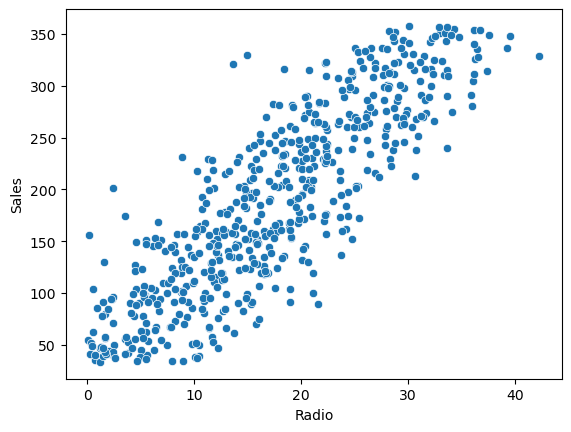

In [18]:
# Create a scatterplot between Radio and Sales.
sns.scatterplot(x = data['Radio'], y = data['Sales'])

The linearity assumption holds for `Radio`, as there is a clear linear relationsship in the scatterplot between `Radio` and `Sales`.

<Axes: xlabel='TV', ylabel='Sales'>

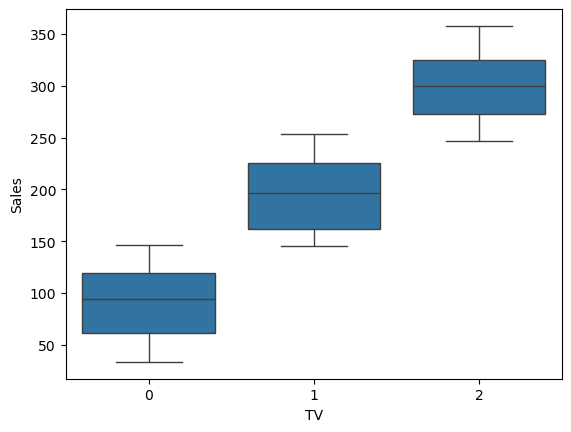

In [19]:
sns.boxplot(x=data['TV'], y=data['Sales'])

Although `TV` is an ordinal categorical variable, the boxplot shows a clear upward trend in `Sales` across increasing levels of `TV` promotion. This pattern supports the linearity assumption, suggesting that `TV` can be reasonably treated as linearly related to `Sales` in the regression model.

### Model Assumption: Independence

The **independent observation assumption** states that each observation in the dataset is independent. As each marketing promotion (i.e., row) is independent from one another, the independence assumption is not violated.

### Model Assumption: Normality

Create the following plots to check the **normality assumption**:

* **Plot 1**: Histogram of the residuals
* **Plot 2**: Q-Q plot of the residuals

<Axes: ylabel='Count'>

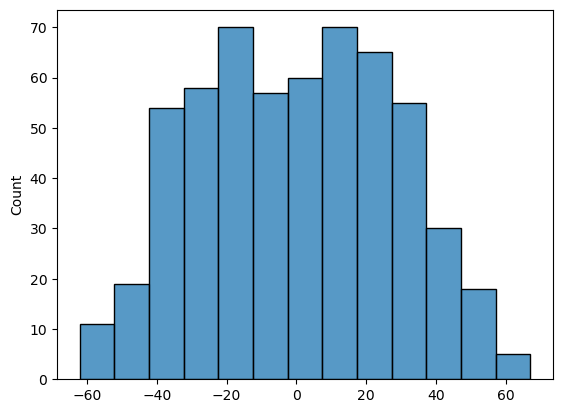

In [20]:
# Calculate the residuals.
residuals = model.resid
sns.histplot(residuals)

#### Steps to Create a Q-Q Plot

A Q-Q plot is a **graphical tool** used to compare the distribution of a sample dataset to a theoretical distribution. Here are the main steps:

---

##### 1. Sort the Sample Data (Order Statistics)

Given a sample dataset $\{x_1, x_2, \dots, x_n\}$, first **sort the data** in ascending order:

$$x_{(1)} \leq x_{(2)} \leq \dots \leq x_{(n)}$$

Here, $x_{(i)}$ is the $i$-th smallest data point.

---

##### 2. Calculate Theoretical Quantile Positions

For each ordered data point, calculate its **plotting position** $p_i$:

$$p_i = \frac{i - 0.5}{n}, \quad i = 1, 2, \dots, n$$

Where $n$ is the sample size.

---

##### 3. Compute Theoretical Quantiles

Use the **inverse cumulative distribution function (quantile function)** $F^{-1}$ of the theoretical distribution to find the **theoretical quantiles** corresponding to each $p_i$:

$$Q_i^{theoretical} = F^{-1}(p_i)$$

For example, if the theoretical distribution is the standard normal, $F^{-1}$ returns the z-scores at probabilities $p_i$.

---

##### 4. Plot the Points

Create points on the Q-Q plot for each $i$:

$$\left( Q_i^{theoretical}, \quad x_{(i)} \right)$$

Where:

* $Q_i^{theoretical}$ is the **theoretical quantile**,
* $x_{(i)}$ is the $i$-th **ordered sample data value**.

---

##### 5. Interpretation

* If the sample data follow the theoretical distribution well, the points will approximately lie on the **45-degree reference line** $y = x$.
* **Deviations** from this line indicate differences between the sample distribution and the theoretical distribution.

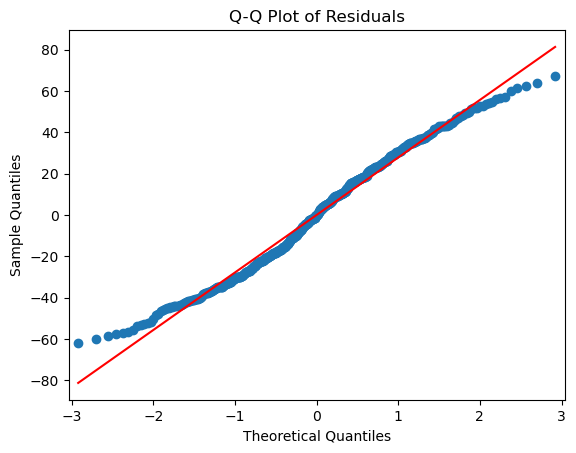

In [21]:
# Create a Q-Q plot of the residuals.

sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')

# Show the plot.
plt.show()

The histogram of the residuals are approximately normally distributed, which supports that the normality assumption is met for this model. The residuals in the Q-Q plot form a straight line, further supporting that this assumption is met.

### Model Assumption: Constant variance

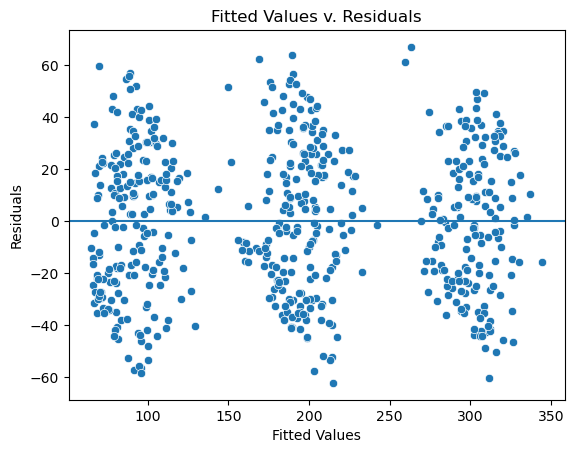

In [22]:
# Create a scatterplot with the fitted values from the model and the residuals.
fig = sns.scatterplot(x = model.fittedvalues, y = model.resid)

# Set the x axis label.
fig.set_xlabel("Fitted Values")

# Set the y axis label.
fig.set_ylabel("Residuals")

# Set the title.
fig.set_title("Fitted Values v. Residuals")

# Add a line at y = 0 to visualize the variance of residuals above and below 0.
fig.axhline(0)

# Show the plot.
plt.show()

The fitted values are in three groups because the categorical variable is dominating in this model, meaning that TV is the biggest factor that decides the sales.

However, the variance where there are fitted values is similarly distributed, validating that the assumption is met.

### Model Assumption: No multicollinearity

The **no multicollinearity assumption** states that no two independent variables ($X_i$ and $X_j$) can be highly correlated with each other. 

Two common ways to check for multicollinearity are to:

* Create scatterplots to show the relationship between pairs of independent variables
* Use the variance inflation factor to detect multicollinearity

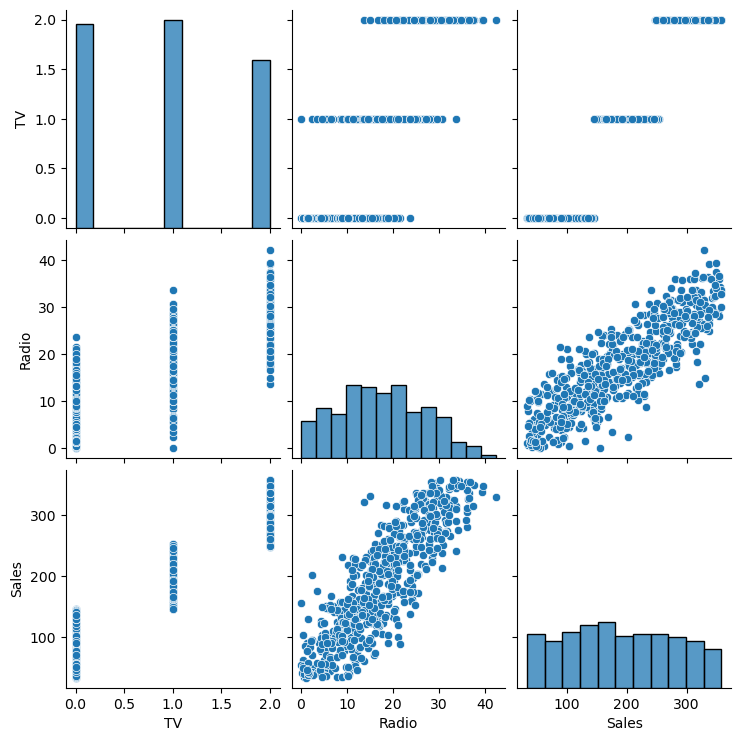

In [23]:
# Create a pairplot of the data.
sns.pairplot(data)

#### 🔍 Multicollinearity Check: VIF

Although VIF (Variance Inflation Factor) can technically be applied when the model includes both ordinal and continuous independent variables, its interpretation may be less reliable in this context.

In this analysis, the `TV` variable is ordinal, and applying VIF directly assumes equal spacing between its levels. Since this assumption may not hold strictly true and could lead to misleading results, the multicollinearity check using VIF was skipped.

Instead, we proceed to the next step of the regression analysis.
#### 🔍 Multicollinearity Check: Variance Inflation Factor (VIF)

**Variance Inflation Factor (VIF)** is a statistical measure used to detect **multicollinearity** among independent variables in a regression model.  
It quantifies how much the variance of a regression coefficient is inflated due to linear relationships with other predictors.

- A **VIF value of 1** indicates no multicollinearity.
- **Values between 1 and 5** suggest moderate correlation but generally acceptable.
- **Values above 5 (or 10)** indicate high multicollinearity, which may distort the model's estimates and interpretations.

---

#### ⚠️ Why VIF Was Not Applied Here

Although VIF can be calculated in models that include both **ordinal** and **continuous** independent variables, applying it directly may lead to misleading results in this context.

In our model:
- The `TV` variable is **ordinal** (low, medium, high encoded as 0, 1, 2).
- Calculating VIF for `TV` assumes that the difference between levels is numerically meaningful and equally spaced, which may **not** accurately reflect the underlying relationships.

Given this limitation, and to avoid potential misinterpretation, the **VIF analysis was intentionally skipped** in this case.

We therefore proceed directly to the next step of the regression analysis.


### Results and evaluation

#### Display the OLS regression results

If the model assumptions are met, we can interpret the model results accurately.

In [24]:
updated_ols_formula = 'Sales ~ TV + Radio' # Define the OLS formula
updated_OLS = ols(formula = updated_ols_formula, data = data) # Create an OLS model.
updated_model = updated_OLS.fit() # Fit the model.
updated_model_results = updated_model.summary() # Save the results summary.
updated_model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     2676.
Date:                Fri, 13 Jun 2025   Prob (F-statistic):          3.70e-290
Time:                        21:12:50   Log-Likelihood:                -2714.3
No. Observations:                 572   AIC:                             5435.
Df Residuals:                     569   BIC:                             5448.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     64.9254      2.580     25.162      0.000      59.857      69.994
TV            77.3156      2.454     31.512      0.000      72.497      82.135
Radio          2.9558      0.211     14.002      0.000       2.541       3.370
==============================================================================
Omnibus:                       60.364   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.980
Skew:                           0.050   Prob(JB):                     0.000125
Kurtosis:                       2.137   Cond. No.                         48.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Using `TV` and `Radio` as the independent variables results in a multiple linear regression model with $R^{2} = 0.904$. In other words, the model explains $90.4\%$ of the variation in `Sales`. This makes the model an excellent predictor of `Sales`. 

#### Interpret model coefficients

With the model fit evaluated, you can look at the coefficient estimates and the uncertainty of these estimates.

When `TV` and `Radio` are used to predict `Sales`, the model coefficients are:

* $\beta_{0} =  64.9254$
* $\beta_{TV}= 77.3156$
* $\beta_{Radio} =  2.9558$

The p-value for all coefficients is $0.000$, meaning all coefficients are statistically significant at $p=0.05$. The 95% confidence intervals for each coefficient should be reported when presenting results to stakeholders. 

For example, there is a $95\%$ chance that the interval $[72.497,82.135]$ contains the true parameter of the slope of $\beta_{TV}$
